# Video Time Series Data Extraction

In [10]:
import numpy as np
import csv
from collections import defaultdict
import os 
import cv2
from matplotlib import pyplot as plt




In [11]:


INPUT_PATH = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/LaSOT/swing/swing/swing-8/img"  # 可以是 "video.mp4" / 0 (摄像头) / "frames_folder"

MAX_CORNERS = 30
QUALITY_LEVEL = 0.05
MIN_DISTANCE = 12
BLOCK_SIZE = 3
USE_HARRIS = False  #  useHarrisDetector=True → 使用 Harris 角点检测  useHarrisDetector=False 使用 Shi-Tomasi 角点检测
K_HARRIS = 0.04  # If useHarrisDetector, don't set it

WIN_SIZE = (21, 21)  ## Original size 21 21 
MAX_LEVEL = 3
TERM_CRITERIA = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)

REDETECT_INTERVAL = 50  
FB_ERR_THRESH = 10.0 # Original 1.5  
ERR_THRESH = 80.0  # Original 30.0

DRAW_TRAJ_LEN = 100      
OUTPUT_CSV = "tracks.csv" 

fgbg = cv2.createBackgroundSubtractorMOG2()

In [12]:
# ========== 统一的帧读取器 ==========
class FrameReader:
    def __init__(self, input_path):
        if isinstance(input_path, int) or input_path.endswith(".mp4") or input_path.endswith(".avi"):
            # 摄像头或视频
            self.mode = "video"
            self.cap = cv2.VideoCapture(input_path)
        elif os.path.isdir(input_path):
            # 图片文件夹
            self.mode = "images"
            files = sorted(os.listdir(input_path))
            self.files = [os.path.join(input_path, f) for f in files if f.lower().endswith((".png", ".jpg", ".jpeg"))]
            self.idx = 0
        else:
            raise ValueError("输入路径不合法: 既不是视频/摄像头，也不是图片文件夹")

    def read(self):
        if self.mode == "video":
            return self.cap.read()
        elif self.mode == "images":
            if self.idx >= len(self.files):
                return False, None
            frame = cv2.imread(self.files[self.idx])
            # print (self.idx)
            self.idx += 1
            return frame is not None, frame

    def release(self):
        if self.mode == "video":
            self.cap.release()
        

## 识别角点,输入是灰度图，输出是角点坐标
def detect_features(gray, mask=None, max_corners=MAX_CORNERS):
    pts = cv2.goodFeaturesToTrack(
        gray,
        maxCorners=max_corners,
        qualityLevel=QUALITY_LEVEL,
        minDistance=MIN_DISTANCE,
        blockSize=BLOCK_SIZE,
        useHarrisDetector=USE_HARRIS,
        k=K_HARRIS,
        mask=mask
    )
    if pts is None:
        return np.empty((0,1,2), dtype=np.float32)
    return np.float32(pts)

from ultralytics import YOLO

model = YOLO("yolov8n.pt")
def detect_features_v2(frame, mask=None, max_corners=200):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    results = model(frame)[0]
    # 初始化 mask
    mask = np.zeros_like(gray, dtype=np.uint8)

    for box in results.boxes.xyxy:  # xyxy = [x1,y1,x2,y2]
        x1, y1, x2, y2 = map(int, box)
        # 在 mask 上画出 ROI
        mask[y1:y2, x1:x2] = 255  

    # 角点检测，只在目标区域
    pts = cv2.goodFeaturesToTrack(
        gray,
        maxCorners=max_corners,
        qualityLevel=0.01,
        minDistance=10,
        mask=mask
    )

    return np.float32(pts) if pts is not None else np.empty((0,1,2), dtype=np.float32), mask


## 
def forward_backward_check(prev_gray, curr_gray, p0):
    # 正向
    p1, st1, err1 = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, p0, None,
        winSize=WIN_SIZE, maxLevel=MAX_LEVEL, criteria=TERM_CRITERIA
    )
    # 反向
    p0_back, st2, err2 = cv2.calcOpticalFlowPyrLK(
        curr_gray, prev_gray, p1, None,
        winSize=WIN_SIZE, maxLevel=MAX_LEVEL, criteria=TERM_CRITERIA
    )
    # 前后向误差
    fb_err = np.linalg.norm(p0 - p0_back, axis=2).reshape(-1)
    err1_ = err1.reshape(-1) if err1 is not None else np.full(len(p0), np.inf)
    st = (st1.reshape(-1) == 1) & (st2.reshape(-1) == 1)
    return p1, st, fb_err, err1_

def in_bounds(p, w, h):
    x, y = p[:,0], p[:,1]
    return (x >= 0) & (x < w) & (y >= 0) & (y < h)


In [13]:
# ========== 主流程 ==========
# cap = cv2.VideoCapture(VIDEO_PATH)

reader = FrameReader(INPUT_PATH)
ok, frame0 = reader.read()
if not ok:
    raise RuntimeError("无法读取输入")

# 记录视频尺寸 h，w， 把首帧转为灰度
h, w = frame0.shape[:2]
prev_gray = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)


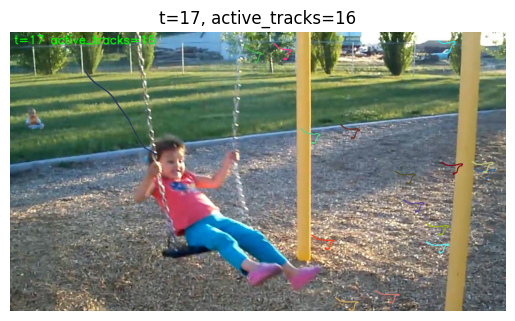

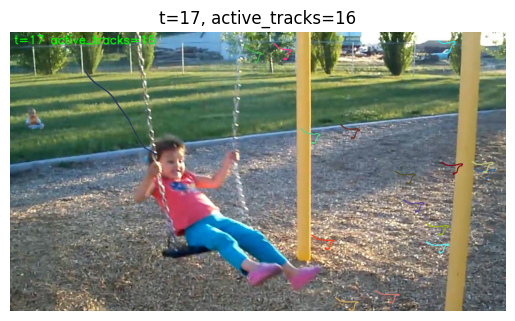

KeyboardInterrupt: 

In [14]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# 初始化角点与轨迹容器
p0 = detect_features(prev_gray, max_corners=MAX_CORNERS)
next_track_id = 0
# 为每个点分配一个track_id
active_ids = []
tracks = defaultdict(list)  # track_id -> [(t,x,y)]
colors = {}

def add_points(points, t):
    global next_track_id
    for pt in points.reshape(-1,2):
        tracks[next_track_id].append((t, float(pt[0]), float(pt[1])))
        active_ids.append(next_track_id)
        colors[next_track_id] = tuple(np.random.randint(0, 255, 3).tolist())
        next_track_id += 1

## 初始化第一帧所识别的所有角点
add_points(p0, t=0)
t = 0

# 用于可视化的轨迹缓存（只保留最近 DRAW_TRAJ_LEN 个）
vis_traj = defaultdict(list)  # track_id -> [(x,y), ...]

plt.ion()  # interactive mode
fig, ax = plt.subplots()

while True:
    ok, frame = reader.read()
    if not ok:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    t += 1
    # print (t)
    # 若还有活跃轨迹：光流跟踪 + 质量筛选 + 更新
    if len(active_ids) > 0:
        # 组织上一帧的点坐标数组（与 active_ids 顺序一致）
        p0_arr = []
        for tid in active_ids:
            xlast, ylast = tracks[tid][-1][1], tracks[tid][-1][2]
            p0_arr.append([xlast, ylast])
        p0_arr = np.float32(p0_arr).reshape(-1,1,2)

        # LK + 前后向一致性
        p1, st, fb_err, err1_ = forward_backward_check(prev_gray, gray, p0_arr)  ## 正向估计新位置，反向验证， p1：本帧估计的新位置 st：前后向都成功的布尔标记 fb_err：前后向回投误差 err1_：正向 LK 误差

        # 质量筛选
        st = st & (fb_err < FB_ERR_THRESH) & (err1_ < ERR_THRESH)
        st = st & in_bounds(p1.reshape(-1,2), w, h)

        # 更新轨迹
        new_active_ids = []
        p1_flat = p1.reshape(-1,2)
        for keep, tid, new_pt in zip(st, active_ids, p1_flat):
            if keep:
                tracks[tid].append((t, float(new_pt[0]), float(new_pt[1])))
                new_active_ids.append(tid)
                # 更新可视化缓存
                vis_traj[tid].append((int(new_pt[0]), int(new_pt[1])))
                if len(vis_traj[tid]) > DRAW_TRAJ_LEN:
                    vis_traj[tid] = vis_traj[tid][-DRAW_TRAJ_LEN:]
        active_ids = new_active_ids

    # 周期性补点（避免与已有点太近）
    if t % REDETECT_INTERVAL == 0:
        mask = np.full((h, w), 255, dtype=np.uint8)
        for tid in active_ids:
            x, y = tracks[tid][-1][1], tracks[tid][-1][2]
            cv2.circle(mask, (int(x), int(y)), MIN_DISTANCE, 0, -1)
        new_pts = detect_features(gray, mask=mask, max_corners=MAX_CORNERS // 2)
        if new_pts is not None and len(new_pts) > 0:
            add_points(new_pts, t)

    vis = frame.copy()
    for tid in active_ids:
        c = colors[tid]
        pts_list = vis_traj[tid]
        for i in range(1, len(pts_list)):
            cv2.line(vis, pts_list[i-1], pts_list[i], c, 2)
        if len(pts_list) > 0:
            cv2.circle(vis, pts_list[-1], 3, c, -1)

    cv2.putText(vis, f"t={t} active_tracks={len(active_ids)}",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0), 2)

    # ---- 用 matplotlib 显示 ----
    # ax.clear()
    # ax.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    # ax.set_title(f"t={t}, active_tracks={len(active_ids)}")
    # ax.axis("off")
    # plt.pause(0.01)
    # print ("hello")
    # prev_gray = gray

    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"t={t}, active_tracks={len(active_ids)}")
    plt.axis("off")
    display(plt.gcf())            
    plt.pause(0.1)
    prev_gray = gray

plt.ioff()
plt.show()

# 导出轨迹到 CSV：列为 track_id, t, x, y
with open(OUTPUT_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["track_id", "t", "x", "y"])
    for tid, seq in tracks.items():
        for (tt, xx, yy) in seq:
            writer.writerow([tid, tt, f"{xx:.3f}", f"{yy:.3f}"])
    print(f"Save_to: {OUTPUT_CSV}")



In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


input_path = "/home/snt/projects_lujun/benchmarking_nature_tsfm/data/video/LaSOT/swing/swing/swing-4/tracks_ts.csv"
result_df = pd.read_csv(input_path)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def interpolate_track(track_df, n_points=50):
    t = np.linspace(0, 1, len(track_df))
    t_new = np.linspace(0, 1, n_points)
    x_new = np.interp(t_new, t, track_df['x'].values)
    y_new = np.interp(t_new, t, track_df['y'].values)
    return np.stack([x_new, y_new], axis=1)

def euclidean_distance_matrix(trajs):
    n = len(trajs)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(trajs[i] - trajs[j])
            dist_matrix[i, j] = dist_matrix[j, i] = dist
    return dist_matrix

def select_most_diverse_tracks(df, max_tracks=5, top_k=10):
    longest_track_len = df.groupby("track_id").size().max()
    track_lengths = df.groupby("track_id").size()
    top_ids = track_lengths.sort_values(ascending=False).head(top_k).index 
    df_top = df[df["track_id"].isin(top_ids)] .copy()

    # 插值轨迹并生成 df_interpolated
    traj_dict = {}
    interpolated_rows = []
    for track_id, track in df_top.groupby("track_id"):
        traj = interpolate_track(track, n_points=longest_track_len)
        traj_dict[track_id] = traj
        for i, (x, y) in enumerate(traj):
            interpolated_rows.append({
                "track_id": track_id,
                "t": i,
                "x": x,
                "y": y
            })
    df_interpolated = pd.DataFrame(interpolated_rows)
    
    track_ids = list(traj_dict.keys())
    
    # 计算距离矩阵
    dist_matrix = euclidean_distance_matrix(list(traj_dict.values()))
    
    # 贪心选择最不相关轨迹
    selected = [0]
    n = len(track_ids)
    while len(selected) < min(max_tracks, n):
        remaining = [i for i in range(n) if i not in selected]
        avg_dists = [np.mean([dist_matrix[i, j] for j in selected]) for i in remaining]
        next_idx = remaining[np.argmax(avg_dists)]
        selected.append(next_idx)
    
    selected_ids = [track_ids[i] for i in selected]
    df_selected = df[df["track_id"].isin(selected_ids)].copy()
    df_interpolated_selected = df_interpolated[df_interpolated["track_id"].isin(selected_ids)].copy()

    return df_selected, df_interpolated, df_interpolated_selected


# 画 X vs t 和 Y vs t
def plot_tracks(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for track_id, track in df.groupby("track_id"):
        axes[0].plot(track["t"], track["x"], label=f"track {track_id}")
        axes[1].plot(track["t"], track["y"], label=f"track {track_id}")

    axes[0].set_title("X vs t")
    axes[0].set_xlabel("t")
    axes[0].set_ylabel("x")

    axes[1].set_title("Y vs t")
    axes[1].set_xlabel("t")
    axes[1].set_ylabel("y")

    # 图例放外面避免遮挡
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [100]:
df_reduced, df_interpolated, df_interpolated_selected = select_most_diverse_tracks(result_df, max_tracks=5, top_k=20)
print(df_interpolated_selected)

       track_id     t           x           y
0             2     0  697.000000  360.000000
1             2     1  698.738211  360.622304
2             2     2  700.710862  361.344347
3             2     3  702.341690  362.123283
4             2     4  703.268429  362.988115
...         ...   ...         ...         ...
57370       142  3820  723.217732  362.823741
57371       142  3821  723.090439  359.224456
57372       142  3822  722.929272  355.779728
57373       142  3823  722.614594  352.298803
57374       142  3824  722.133000  348.416000

[19125 rows x 4 columns]


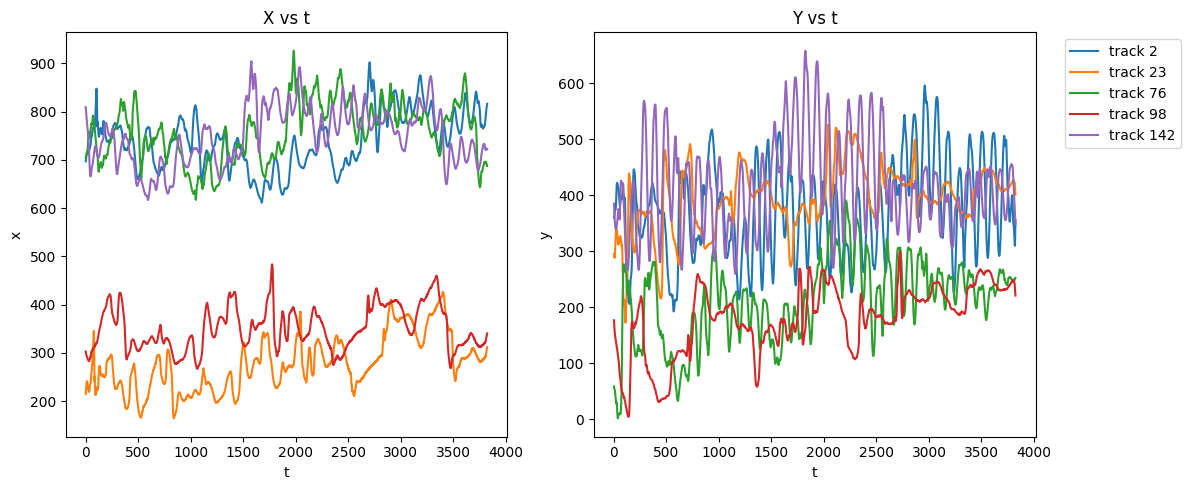

In [101]:

plot_tracks(df_interpolated_selected)

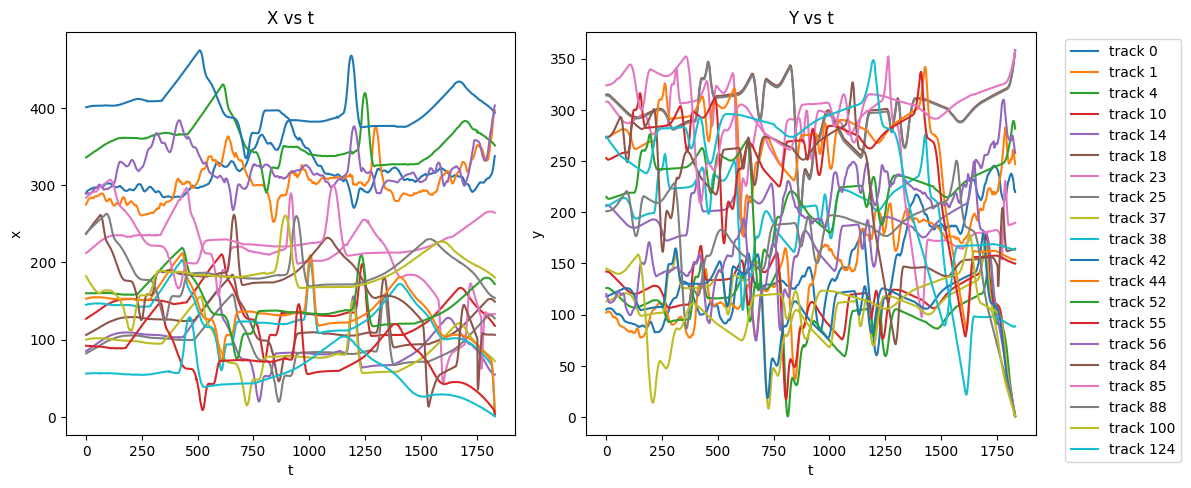

In [94]:
plot_tracks(df_interpolated)